# Сокращение размерности

### EM алгоритм

Напомним, как выглядит $EM$ алгоритм. 

$$
\log p(x|\theta) = \int q(z)\log p(x|\theta)dz = \int q(z)\log\dfrac{p(x,z|\theta)}{p(z|x,\theta)}dz = \int q(z)\log\dfrac{p(x,z|\theta)}{q(z)}dz+\int q(z)\log\dfrac{q(z)}{p(z|x,\theta)}dz = \mathcal{L}(q,\theta)+KL(q(z)|p(z|x,\theta))
$$

** E-step ** 
$$ q(z)^{(n+1)} = p(z|x,\theta^{(n)}) $$
** M-step ** 
$$ \theta^{(n+1)} = \max\limits_{\theta} \mathcal{L}(q^{(n+1)},\theta) $$

### PCA как модель с латентными пременными

Процесс генерации данных в модели PCA выглядит следующим образом:

![Генеративный процесс](pca_illustration.png "Генеративный процесс")

Таким образом, мы получаем модель:

\begin{equation}P(X,T|W,\mu,\sigma^2) = \prod\limits_{n=1}^{N}p(x_n,t_n|W,\mu,\sigma^2) = \prod\limits_{n=1}^{N}\mathcal{N}(x_n|Wt_n+\mu,\sigma^2I)\mathcal{N}(t_n|0,I)
\end{equation}

** Задание 1. ** (5 баллов) Выпишите E и M шаги для модели PCA.

Необходимо решить задачу максимизации правдоподобия:
$$p(X|W, \mu, \sigma^2) = \prod_{n=1}^N p(x_n|W, \mu, \sigma^2) \to \max_{W,\mu,\sigma^2}$$

- ### E step

 $$p(T|X, W, \mu, \sigma^2) = \prod_{n=1}^N p(t_n|x_n, W, \mu, \sigma^2)$$

 $$p(t|x, W, \mu, \sigma^2) = \frac{p(t, x|W, \mu, \sigma^2)}{p(x|W,\mu, \sigma^2)} = \frac{p(x|t,W,\mu,\sigma^2)p(t)}{\int p(x|t, W, \mu, \sigma^2)p(t)dt}
\stackrel{(1)}{=}\frac{\mathcal{N}(x|Wt + \mu, \sigma^2I)\mathcal{N}(t|0,I)}{\mathcal{N}(x|\mu, WW^T + \sigma^2I)}\stackrel{(2)}{=}
\stackrel{(2)}{=}\mathcal{N}\left(t|(W^TW + \sigma^2I)^{-1}W^T(x-\mu),(I + \sigma^{-2}W^TW)^{-1}\right)$$

 1) $\int p(x|t, W, \mu, \sigma^2)p(t)dt$ — свёртка плотностей нормального распределения $\Rightarrow$ полученная плотность является плотностью нормального распределения. При этом математическое ожидание и дисперсию полученного распределения можно посчитать. Пусть $\varepsilon \sim \mathcal{N}(0, \sigma^2I)$, тогда:
 
 $$\mathbb{E}x = \mathbb{E}\left[Wt + \mu + \varepsilon\right] = \mu$$
 $$\mathbb{V}x = \mathbb{E}\left[(x - \mu)(x - \mu)^T\right]
 =\mathbb{E}x\left[(Wt + \varepsilon)(Wt + \varepsilon)^T\right]
 =W\mathbb{E}\left[tt^T\right]W^T + \mathbb{E}\left[\varepsilon\varepsilon^T\right] = WW^T + \sigma^2I$$
 
 2) $$\frac{\mathcal{N}(x|Wt + \mu, \sigma^2I)\mathcal{N}(t|0,I)}{\mathcal{N}(x|\mu, WW^T + \sigma^2I)} 
     =C_1\exp\left(-\frac{1}{2}C_2\right)$$
 
    $$C_1 =\left(\frac{1}{2\pi\sigma^2}\right)^{\frac{D}{2}}\left(\frac{1}{2\pi}\right)^{\frac{d}{2}} (2\pi)^{\frac{D}{2}}\left|WW^T+\sigma^2 I\right|^{\frac{1}{2}} = \left(\frac{1}{2\pi}\right)^{\frac{d}{2}}\left|I+\sigma^{-2}WW^T\right|^{\frac{1}{2}}$$
 
- ### M step

$$\mu_{\text{new}} = \frac{1}{N}\sum_{n=1}^N x_n$$

$$W_{\text{new}} = \left(\sum_{n=1}^N(x_n - \mu_{\text{new}})\mathbb{E}t_n^T\right)\left(\sum_{n=1}^N\mathbb{E}t_nt_n^T\right)^{-1}$$

$$\sigma^2_{\text{new}} = \frac{1}{ND}\sum_{n=1}^N \left((x_n - \mu_{\text{new}})^T(x_n - \mu_{\text{new}}) - 2\mathbb{E}t_n^TW^T_{\text{new}}(x_n - \mu_{\text{new}}) + \text{tr} W_{\text{new}}^TW_{\text{new}}\mathbb{E}t_nt_n^T\right)$$

Здесь $\mathbb{E}t_n$ и $\mathbb{E}t_nt_n^T$, считаются с помощью распределения, полученного в E-step.

** Задание 2. ** (5 баллов) Реализуйте EM алгоритм для модели PCA

Т.к. $\mu$ не изменяется на итерациях, центрируем данные и будет считать $\mu=0$.

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np

class EM_encoder:
    def __init__(self, d, max_iter=100):
        self.scaler = StandardScaler(with_std=False)
        self.W = None
        self.sigma2 = None
        self.d = d
        self.max_iter = max_iter
        
    def make_step(self, X):
        # E-step
        M = np.linalg.inv(self.W.T @ self.W + self.sigma2* np.identity(self.d))
        Sigma = self.sigma2 * M
        means = np.apply_along_axis(lambda x:M @ self.W.T @ x, 1, X)
        
        # M-step
        self.W = sum(X[i][:,np.newaxis] @ means[i][:,np.newaxis].T for i in range(X.shape[0]))\
               @ np.linalg.inv(X.shape[0] * Sigma + sum(mean[:,np.newaxis] @ mean[:,np.newaxis].T
                                                        for mean in means))

        self.sigma2 = sum((X[i]**2).sum() - 2 * means[i][:,np.newaxis].T @ self.W.T @ X[i][:,np.newaxis]
                          + np.trace(self.W.T @ self.W @ (Sigma + means[i][:,np.newaxis] @ means[i][:,np.newaxis].T))
                              for i in range(X.shape[0])) / X.size
        
    def fit(self, X, W=None, sigma2=None):
        if W is None:
            self.W = np.random.uniform(0, 1, (X.shape[1], self.d))
        else:
            self.W = W
        if sigma2 is None:
            self.sigma2 = 1
        else:
            self.sigma2 = sigma2
            
        X_copy = self.scaler.fit_transform(X)
        for i in range(self.max_iter):
            self.make_step(X_copy)
            
    def transform(self, X):
        return np.apply_along_axis(lambda x:np.linalg.inv(self.sigma2 + self.W.T @ self.W)\
                                            @ self.W.T @ x,
                                   1, self.scaler.transform(X))

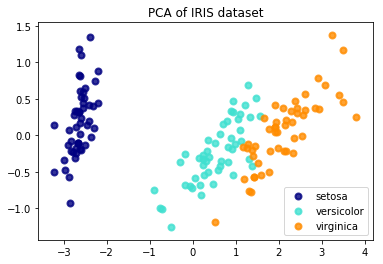

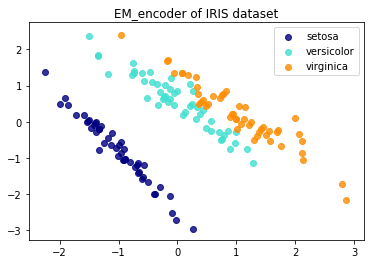

In [6]:
# check with iris

import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

em_encoder = EM_encoder(2, 1000)
em_encoder.fit(X)
X_r2 = em_encoder.transform(X)

# Percentage of variance explained for each components
#print('explained variance ratio (first two components): %s'
#      % str(pca.explained_variance_ratio_))

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('EM_encoder of IRIS dataset')

plt.show()

** Задание 3. ** (10 баллов) Используя свою реализацию метода PCA, решите задачу восстанавления давления по профилю крыла.

Скачать данные со страницы курса. https://yadi.sk/i/065iNGXp3QYv5n

Данные представляют собой матрицу размера $397\times114$; в каждой
строке находится подвектор, описывающий профиль (первые 57
координат), и подвектор, описывающий соответствующее распределение
давления (следующие 57 координат). Задача состоит в том, чтобы на
основании метода главных компонент построить алгоритм, позволяющий
восстанавливать распределение давления по профилю. Опишем алгоритм
обучения и алгоритм восстановления. Пусть ${\bf A}\in\mathbb{R}^{57}$ --
вектор, описывающий профиль, а ${\bf P}\in\mathbb{R}^{57}$ -- вектор,
описывающий распределение давления. Дана обучающая выборка $({\bf
A}_i,{\bf P}_i)_{i=1}^N$ (взять в качестве обучающей выборки 75%
случайно выбранных строк из матрицы данных; остальные 25%
использовать в качестве тестового множества данных).

Алгоритм обучения состоит из следующих шагов:


1. По данным $({\bf A}_i,{\bf P}_i)_{i=1}^N$ оцениваются первые
$d$ (параметр алгоритма) главных компонент ${\bf e}_1,\ldots,{\bf
e}_d$, где ${\bf e}_i\in\mathbb{R}^{114}$. 
2. Каждый из векторов ${\bf e}_i,i=1,\ldots,d$ представляется как объединение двух подвекторов
${\bf e}_i = ({\bf e}_i^A\in\mathbb{R}^{57},{\bf
e}_i^P\in\mathbb{R}^{57}),i=1,\ldots,d$, соответствующих описанию профиля
и распределению давления соответственно.


Преобразование произвольного объединенного вектора ${\bf Z} =
({\bf A},{\bf P})$ в сжатое описание ${\bf\lambda}=(\lambda_1,\ldots,\lambda_d)$ происходит согласно
следующей формуле:

$$
\lambda_i = \left( {\bf Z}-{\bf Z}_{\mathrm{mean}},{\bf e}_i\right),
i=1,\ldots,d,
$$

где ${\bf Z}_{\mathrm{mean}} = \frac{1}{N}\sum_{k=1}^N {\bf Z}_k$,
${\bf Z}_k = ({\bf A}_k,{\bf P}_k)$ (выборочное среднее;
подсчитывается по обучающей выборке). Восстановления подвекторов
${\bf A}$ и ${\bf P}$ объединенного вектора ${\bf Z} = ({\bf
A},{\bf P})$ по сжатому описанию ${\bf
\lambda}=(\lambda_1,\ldots,\lambda_d)$ происходит согласно
формулам

$$
{\bf A}^*({\bf \lambda}) = {\bf A}_{\mathrm{mean}} + \sum_{i=1}^d\lambda_i{\bf e}_i^A,\,{\bf
P}^*({\bf \lambda}) ={\bf P}_{\mathrm{mean}} + \sum_{i=1}^d\lambda_i{\bf e}_i^P.
$$


Алгоритм восстановления давления ${\bf P}$ по профилю ${\bf A}$
может быть описан следующим образом:


1. Для заданного профиля ${\bf A}$ определяются такие ${\bf
\lambda}=(\lambda_1,\ldots,\lambda_d)$, что $\|{\bf A}^*({\bf
\lambda})-{\bf A}\|_{2}^2$ принимает минимальное значение (такое
значение ${\bf \lambda}$ подсчитывается с помощью псевдообращения
матрицы $E=[{\bf e}_1^A,\ldots,{\bf e}_d^A]$, то есть ${\bf
\lambda} = E^{+}\left({\bf A}-{\bf A}_{\mathrm{mean}}\right)$, где $E^+$ -- псевдообратная матрица).
2. По вычисленному вектору ${\bf
\lambda}$ оценивается давление согласно формуле ${\bf P}^*({\bf
\lambda}) = {\bf P}_{\mathrm{mean}} + \sum_{i=1}^d\lambda_i{\bf e}_i^P.
$

Задача состоит в том, чтобы реализовать предложенный алгоритм;
подсчитать график зависимости средней ошибки восстановления
векторов давлений из тестовой выборки от размерности сжатия $d$;
нарисовать несколько восстановленных графиков давления (для
нескольких разных профилей) с наложением истинных значений
давления. Ошибка между набором векторов $({\bf P}_i)_{i=1}^M$ и
восстановленными векторами $({\bf P}^*_i)_{i=1}^M$ оценивается
согласно формуле $\sqrt{\frac{1}{M}\sum_{i=1}^M\|{\bf P}_i-{\bf P}^*_i\|^2}$, где
$\|\cdot\|$ -- евклидово расстояние

In [121]:
from sklearn.model_selection import train_test_split

In [122]:
data = np.fromfile('A2P.txt', sep=' ').reshape(397, 114)
A = data[:,57]
P = data[:,58:]
A_train, P_train, A_test, P_test = train_test_split(A, P, test_size=0.25)